<a href="https://colab.research.google.com/github/lakshayt7/Bandit-Optimization-Algorithms/blob/main/Bandit_Online_Gradient_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Neccesary Libraries

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import cvxpy as cp

In [ ]:
def minimize_l2(eta, theta):
    #minimizes the L2 objective specified in the Algorithm
    w = cp.Variable(np.shape(theta))
    objective = cp.Minimize(cp.atoms.norm(w - eta*theta))
    constraints = [cp.atoms.norm(w)<=1]
    prob = cp.Problem(objective, constraints)
    sol =  prob.solve()
    return w.value
def reward(para, action):
    #returns the reward for some action and set of parameters
    return para[0] + np.dot(para[1:], action)
def sample_spherical(n):
    #samples from the unit sphere 
    cov = np.eye(n)
    mu = np.zeros((n))
    x = np.random.multivariate_normal(mu, cov, 1)
    if x.any() == 0:
        x = np.ones(n)
    x = x/np.linalg.norm(x, ord=2)
    return x

Define the Player and Adversary Classes with neccesary parameters

In [ ]:
class Player:
    def __init__(self, score, theta, eta, delta, d):
        self.score = score
        self.theta = theta
        self.eta = eta
        self.delta = delta
        self.v = 0
        self.d = d
        self.w = minimize_l2(eta, theta)
    def predict_action(self):
        #predict action given current set of parameters
        v = sample_spherical(self.d)
        self.v = v
        action =  self.w + delta*v
        return action[0]
    def update_parameters(self, reward):
        #update the parameters for some reward recieved
        z = (self.v/self.delta)*reward
        self.score = self.score + reward
        self.theta = self.theta - z
        self.w = minimize_l2(self.eta, self.theta)

class Adversary:
    def __init__(self, cost_dict):
        self.costs = cost_dict
    def random_costs(self, action):
        #returns a random cost from the set of cost functions available to adversary
        n = np.shape(self.costs)[0]
        ind = random.randint(0,n-1)
        x = cp.Variable(np.shape(action)[0])
        cost = self.costs[ind]
        objective = cp.Minimize(cost[0] + np.squeeze(cost[1:])@x)
        constraints = [cp.atoms.norm(x)<=1]
        prob = cp.Problem(objective, constraints)
        sol =  prob.solve()
        return reward(self.costs[ind], action), sol
    def worst_costs(self, action):
        #returns worst cost out of set of cost functions available to Adversary
        n = np.shape(self.costs)[0]
        cost = reward(self.costs[0], action)
        for i in range(n):
            cost = max(cost, reward(self.costs[i], action))
        return cost
           
        

In [ ]:
def Bandit_OGD(d, ncosts, T, eta, delta):
    #Bandit OGD Algorithm returns the Regrets
    regrets = []
    #choose ncost number of random cost functions
    cov = 20*np.eye(d)
    mu = np.zeros((d))
    x = np.random.multivariate_normal(mu, cov, ncosts)
    cs = np.zeros((ncosts, 1))
    for i in range(ncosts):
        c = random.randint(1, 50)
        cs[i] = c
    costs = np.hstack((cs, x))
    #Define the Adversary based on chosen cost functions
    A = Adversary(costs)
    regret = 0
    #Define a player with 0 initial score and given parameters
    P = Player(0, np.zeros(d), eta, delta, d)
    for i in range(T):
        action = P.predict_action()
        cost, op = A.random_costs(action)
        regret = regret + cost - op
        P.update_parameters(cost)
        regrets.append(regret)
    del P
    del A
    return regrets

Bandit OGD Parameter Senstivity Analysis

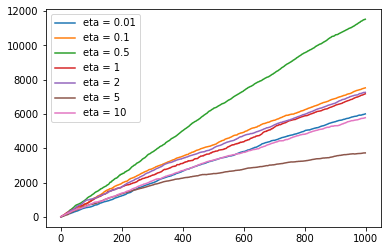

In [ ]:
T = 1000
d = 6
eta = 0.5
delta = 1
ncosts = 3
ts = np.arange(T)
#Bandit OGD run on different eta values
etas = [0.01, 0.1, 0.5, 1, 2, 5, 10]
ts = np.arange(T)
for eta in etas:
    regret = Bandit_OGD(d, ncosts, T, eta, delta)
    plt.plot(ts, regret, label = "eta = " + str(eta) )
plt.legend()

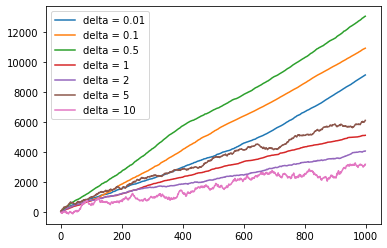

In [ ]:
T = 1000
d = 6
eta = 0.5
delta = 1
ncosts = 3
ts = np.arange(T)
#Bandit OGD run on different delta values
deltas = [0.01, 0.1, 0.5, 1, 2, 5, 10]
ts = np.arange(T)
for delta in deltas:
    regret = Bandit_OGD(d, ncosts, T, eta, delta)
    plt.plot(ts, regret, label = "delta = " + str(delta) )
plt.legend()

Senstivity to Adversary Parameters

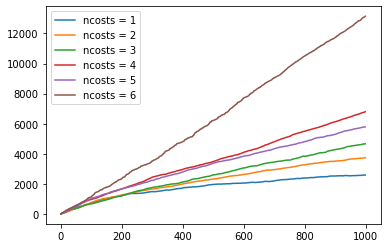

In [ ]:
T = 1000
d = 6
eta = 0.5
delta = 1
ncosts = 3
ts = np.arange(T)
#Bandit OGD run on different number of costs values
ncosts = [1, 2, 3, 4, 5, 6]
ts = np.arange(T)
for ncost in ncosts:
    regret = Bandit_OGD(d, ncost, T, eta, delta)
    plt.plot(ts, regret, label = "ncosts = " + str(ncost) )
plt.legend()

Comparison with theoretical bounds

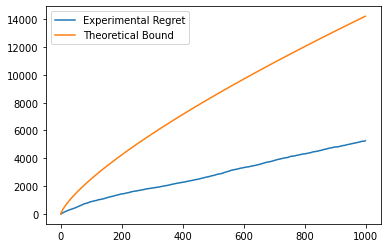

In [ ]:
T = 1000
d = 6
eta = 0.5
delta = 1
ncosts = 3
ts = np.arange(T)
bound = np.power(ts,3/4)*80
regret = Bandit_OGD(d, ncosts, T, eta, delta)
plt.plot(ts, regret, label = "Experimental Regret")
plt.plot(ts, bound, label = "Theoretical Bound")
plt.legend()